# Training neural network to predict ball position in a 3d space
## 1. Importing Libraries

In [142]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from utils.evaluate import evaluate_model
from utils.plot_maker_gaussian_process import plot_maker_3d

## 2. Importing Data

In [143]:
# get all train data
X_train_circle = pd.read_csv('../data/data-train-circle/red_ball_coordinates_128px_2024-03-05_18h54m.csv', decimal='.', delimiter=',')
X_train_curve = pd.read_csv('../data/data-train-curve/red_ball_coordinates_128px_2024-03-06_19h13m.csv', decimal='.', delimiter=',')
X_train_spiral = pd.read_csv('../data/data-train-spiral/red_ball_coordinates_128px_2024-03-06_18h56m.csv', decimal='.', delimiter=',')
X_train_circle.shape, X_train_curve.shape, X_train_spiral.shape

((646, 14), (799, 14), (618, 14))

In [144]:
# get all the position data
y_train_circle = pd.read_csv('../data/data-train-circle/positions_xyz_2024-03-05_18h54m.csv', decimal='.', delimiter=',')
y_train_curve = pd.read_csv('../data/data-train-curve/positions_xyz_2024-03-06_19h13m.csv', decimal='.', delimiter=',')
y_train_spiral = pd.read_csv('../data/data-train-spiral/positions_xyz_2024-03-06_18h54m.csv', decimal='.', delimiter=',')
y_train_circle.shape, y_train_curve.shape, y_train_spiral.shape

((650, 3), (803, 3), (622, 3))

In [145]:
# remove first 4 rows of the data
y_train_circle = y_train_circle.iloc[4:]
y_train_curve = y_train_curve.iloc[4:]
y_train_spiral = y_train_spiral.iloc[4:]
y_train_circle.shape, y_train_curve.shape, y_train_spiral.shape

((646, 3), (799, 3), (618, 3))

In [146]:
# concatenate all the data
X_train = pd.concat([X_train_circle, X_train_curve, X_train_spiral])
y_train = pd.concat([y_train_circle, y_train_curve, y_train_spiral])
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_train.shape, y_train.shape

((2063, 14), (2063, 3))

## 3. Data Preprocessing

In [147]:
combined = pd.concat([X_train, y_train], axis=1)
combined

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,61.0,83.0,42.0,92.5,59.0,75.0,52.0,75.0,36.0,76.0,42.0,69.5,44.0,68.5,10.139580,3.359998,22.34200
1,61.0,83.0,42.0,93.0,59.0,75.0,52.0,75.0,36.0,76.0,42.0,69.5,23.5,69.5,10.138330,3.409981,22.39198
2,60.5,83.0,42.0,93.0,59.0,76.0,52.0,75.0,36.0,77.0,42.0,69.5,23.5,69.5,10.136250,3.459938,22.44194
3,61.0,83.0,42.0,93.0,59.5,76.0,32.0,75.0,36.0,77.0,42.0,70.0,23.5,69.5,10.133340,3.509852,22.49185
4,61.0,83.0,2.0,86.0,60.0,76.0,32.0,75.0,36.0,77.5,42.0,70.0,23.5,69.5,10.129590,3.559711,22.54171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,92.0,70.0,75.0,80.0,90.5,63.0,83.5,62.5,67.0,63.0,72.0,56.0,75.0,56.0,5.352216,1.263333,22.12592
2059,92.5,70.0,75.0,80.0,90.5,63.0,83.5,62.5,67.0,63.0,72.0,56.0,75.0,56.0,5.367581,1.260000,22.00724
2060,92.5,69.5,75.0,80.0,91.0,63.0,83.5,62.5,67.0,63.0,72.0,56.0,75.0,56.0,5.390812,1.256666,21.88988
2061,92.5,69.5,75.0,80.0,91.0,63.0,83.5,62.5,67.0,63.0,72.0,56.0,75.0,56.0,5.421805,1.253333,21.77434


In [148]:
# check for missing values
print(f'The data has missing values: {combined.isnull().sum().sum()}')
combined.dropna(inplace=True)
combined.shape

The data has missing values: 6


(2060, 17)

In [149]:
X = combined.iloc[:, :14]
y = combined.iloc[:, 14:]

In [150]:
# scale the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

## 4. Hyperparameter Tuning

In [151]:
# create a pipeline
pipeline = Pipeline([
    ('mlp', MLPRegressor(random_state=42))
])

In [152]:
param_grid = {
    'mlp__hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'mlp__activation': ['identity', 'tanh', 'relu'],
    'mlp__solver': ['sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [10000, 20000, 28000],
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__early_stopping': [True],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, n_iter=100, n_jobs=-1, verbose=3, random_state=42)

random_search.fit(X_scaled, y_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\xande\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\xande\venv\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\xande\venv\lib\site-

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('mlp',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'mlp__activation': ['identity', 'tanh',
                                                            'relu'],
                                        'mlp__alpha': [0.001, 0.01, 0.1],
                                        'mlp__early_stopping': [True],
                                        'mlp__hidden_layer_sizes': [(50, 50,
                                                                     50),
                                                                    (50, 100,
                                                                     50),
                                                                    (100,)],
                                        'mlp__learning_rate': ['constant',
                                                               'adaptive'],
                                        'mlp__learning_rate_init': [0.001, 0.01,
                                                                    0.1],
                                        'mlp__max_iter': [10000, 20000, 28000],
                                        'mlp__solver': ['sgd', 'adam']},
                   random_state=42, verbose=3)

In [153]:
print(f'Best parameters: {random_search.best_params_}')
print(f'Best score: {random_search.best_score_}')

Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 20000, 'mlp__learning_rate_init': 0.001, 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (50, 50, 50), 'mlp__early_stopping': True, 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}
Best score: 0.8308854924091713


In [154]:
model = random_search.best_estimator_

## 5. Training the Model

In [155]:
model.fit(X_scaled, y_scaled)

Pipeline(steps=[('mlp',
                 MLPRegressor(alpha=0.01, early_stopping=True,
                              hidden_layer_sizes=(50, 50, 50), max_iter=20000,
                              random_state=42))])

## 6. Make Predictions On Test Data

In [156]:
# get all test data
X_test_circle = pd.read_csv('../data/data-test-circle/red_ball_coordinates_128px_2024-03-05_18h59m.csv', decimal='.', delimiter=',')
X_test_curve = pd.read_csv('../data/data-test-curve/red_ball_coordinates_128px_2024-03-06_19h16m.csv', decimal='.', delimiter=',')
X_test_spiral = pd.read_csv('../data/data-test-spiral/red_ball_coordinates_128px_2024-03-06_18h57m.csv', decimal='.', delimiter=',')
X_test_circle.shape, X_test_curve.shape, X_test_spiral.shape

((299, 14), (308, 14), (387, 14))

In [157]:
# get all the position data
y_test_circle = pd.read_csv('../data/data-test-circle/positions_xyz_2024-03-05_18h59m.csv', decimal='.', delimiter=',')
y_test_curve = pd.read_csv('../data/data-test-curve/positions_xyz_2024-03-06_19h16m.csv', decimal='.', delimiter=',')
y_test_spiral = pd.read_csv('../data/data-test-spiral/positions_xyz_2024-03-06_18h57m.csv', decimal='.', delimiter=',')
y_test_circle.shape, y_test_curve.shape, y_test_spiral.shape

((303, 3), (312, 3), (391, 3))

In [158]:
# remove first 4 rows of the data
y_test_circle = y_test_circle.iloc[4:]
y_test_curve = y_test_curve.iloc[4:]
y_test_spiral = y_test_spiral.iloc[4:]
y_test_circle.shape, y_test_curve.shape, y_test_spiral.shape

((299, 3), (308, 3), (387, 3))

In [169]:
# concatenate all the data
#X_test = pd.concat([X_test_circle, X_test_curve, X_test_spiral])
#y_test = pd.concat([y_test_circle, y_test_curve, y_test_spiral])
X_test = X_test_spiral
y_test = y_test_spiral
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

combined_test = pd.concat([X_test, y_test], axis=1)
combined_test

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,61.0,83.0,44.0,93.0,60.0,76.0,53.0,76.0,36.0,76.0,42.0,69.5,44.5,69.0,10.133140,3.303333,22.49184
1,61.0,83.0,44.0,93.0,60.0,76.0,53.0,76.0,36.0,76.0,42.0,69.0,44.5,69.0,10.112840,3.296667,22.69074
2,62.0,83.0,44.0,93.0,60.0,75.5,53.0,75.5,36.0,76.0,42.0,69.0,44.5,69.0,10.079350,3.290000,22.88784
3,62.0,83.0,44.0,93.0,60.5,75.5,53.0,75.0,37.0,76.0,43.0,69.0,45.0,69.0,10.032810,3.283333,23.08224
4,62.0,82.0,45.0,93.0,60.5,75.5,54.0,75.0,37.5,75.5,43.0,68.5,45.5,68.5,9.973422,3.276667,23.27308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,63.5,67.0,46.0,77.0,62.0,60.0,55.0,60.0,38.0,60.0,43.5,52.5,46.0,53.0,9.785061,0.756666,23.41216
383,64.0,67.0,47.0,77.0,62.0,60.0,55.5,60.5,38.0,60.0,44.0,53.0,47.0,53.0,9.704265,0.750000,23.58574
384,64.0,67.5,47.0,77.0,63.0,60.0,56.0,60.0,39.0,60.0,45.0,53.0,47.5,52.5,9.612098,0.743333,23.75351
385,66.0,67.0,48.0,77.0,64.0,60.0,57.0,60.0,40.0,60.0,46.0,53.0,48.0,53.0,9.508967,0.736666,23.91476


In [170]:
# check for missing values
print(f'The data has missing values: {combined_test.isnull().sum().sum()}')
combined_test.dropna(inplace=True)
combined_test.shape

The data has missing values: 0


(387, 17)

In [171]:
X_test = combined_test.iloc[:, :14]
y_test = combined_test.iloc[:, 14:]
X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [172]:
y_test_pred_scaled = model.predict(X_test_scaled)

In [173]:
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_pred

array([[ 9.95679061,  3.19279119, 21.96401953],
       [ 9.94243275,  3.19041747, 22.15539344],
       [ 9.9252238 ,  3.17486424, 22.16008491],
       ...,
       [ 9.19404039,  0.8691896 , 19.63857742],
       [ 9.1631853 ,  0.84913666, 19.64905479],
       [ 9.17398333,  0.82517293, 19.48006434]])

In [174]:
evaluate_model(y_test, y_test_pred, 'Test Data')

Mean Squared Error on Test Data Set: 0.684154964948214
Mean Absolute Error on Test Data Set: 0.49518062821521697
R2 Score on Test Data set: 0.8344787293501333


(0.684154964948214, 0.49518062821521697, 0.8344787293501333)

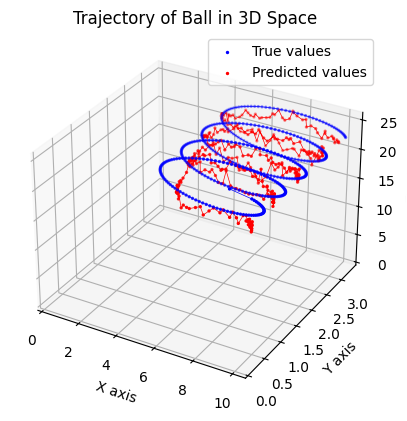

In [175]:
plot_maker_3d(y_test.to_numpy(), y_test_pred, 'Trajectory of Ball in 3D Space')